In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
import numpy as np
from numpy import array

import seaborn as sns
import matplotlib.pyplot as plt
import datetime

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import scipy
from scipy import stats,interpolate
from scipy.stats import skew,kurtosis,describe,variation,shapiro,levene,f_oneway
from scipy.special import kl_div
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

import warnings 
warnings.filterwarnings(action='ignore')

import optuna
from optuna.integration import XGBoostPruningCallback
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import GridSearchCV,cross_validate
from sklearn import model_selection
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold, KFold 
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,AdaBoostClassifier,IsolationForest,StackingClassifier
from sklearn.metrics import accuracy_score,balanced_accuracy_score,precision_score,recall_score,confusion_matrix,f1_score,fbeta_score,roc_auc_score,classification_report,make_scorer,balanced_accuracy_score
from mlxtend.classifier import StackingClassifier,StackingCVClassifier
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler,MinMaxScaler,RobustScaler,Binarizer

from imblearn.over_sampling import SMOTE,ADASYN,BorderlineSMOTE,SVMSMOTE
from imblearn.combine import SMOTEENN,SMOTETomek
from imblearn.under_sampling import RandomUnderSampler,NearMiss,TomekLinks,CondensedNearestNeighbour,EditedNearestNeighbours

import random
import tensorflow 
import tensorflow as tf

random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
def describex(data):
        data = pd.DataFrame(data)
        stats = data.describe()
        skewness = data.skew()
        kurtosis = data.kurtosis()
        skewness_df = pd.DataFrame({'skewness':skewness}).T
        kurtosis_df = pd.DataFrame({'kurtosis':kurtosis}).T
        Appended_Stats = pd.concat([stats,skewness_df,kurtosis_df],axis=0)
        return Appended_Stats

In [3]:
def get_clf_eval(y_test,pred=None,pred_proba=None):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    roc_auc = roc_auc_score(y_test,pred_proba)
    f1 = f1_score(y_test,pred)
    f2 = fbeta_score(y_test,pred,beta=2)
    balanced_acc = balanced_accuracy_score(y_test,pred)
    print('Confusion Matrix')
    print(confusion)
    print('\n')
    print('정확도:',accuracy.round(3),'정밀도:', precision.round(3),'재현율:',recall.round(3),'AUC:',roc_auc.round(3),'F1:',f1.round(3),'F2:',f2.round(3),'Balanced_Accuracy:',balanced_acc.round(3))

In [4]:
data = pd.read_csv('predictive_maintenance.csv')
data = data.drop(['Failure Type'],axis=1)
data = data.rename(columns={'Air temperature [K]':'Air_Temperature','Process temperature [K]':'Process_Temperature','Rotational speed [rpm]':'Rotational_Speed','Torque [Nm]':'Torque','Tool wear [min]':'Tool_Wear'})

In [5]:
data.head()

,UDI,Product ID,Type,Air_Temperature,Process_Temperature,Rotational_Speed,Torque,Tool_Wear,Target
0,1,M14860,M,298.1,308.6,1551,42.8,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0


In [6]:
data.dtypes

UDI                      int64
Product ID              object
Type                    object
Air_Temperature        float64
Process_Temperature    float64
Rotational_Speed         int64
Torque                 float64
Tool_Wear                int64
Target                   int64
dtype: object

In [7]:
Data = data
Target = 'Target'
Input_Data = data.drop(['UDI','Product ID','Type','Target'],axis=1)

In [8]:
Input_Data.shape

(10000, 5)

#### 1. 통계분석

In [9]:
def Analysis(Data,Target,Input_Data):
    
    Stats = describex(Input_Data)
    
    print('Class Count','\n',Data[Target].value_counts(),'\n')
    print('Normal', round(Data[Target].value_counts()[0]/len(Data) * 100,2), '% of the dataset')
    print('Fault', round(Data[Target].value_counts()[1]/len(Data) * 100,2), '% of the dataset')
    print('Imbalanced Ratio(IR):',round(Data[Target].value_counts()[0]/Data[Target].value_counts()[1]*1,2),'%')
    
    sns.set(font_scale=1.0)
    plt.figure(figsize=(3.5,3))
    plt.grid(True)
    plt.title('Machine  \n (0: Normal || 1: Fault)', fontsize=11)
    colors = ["blue", "red"]
    sns.countplot(x= Target, data=Data,palette=colors)
    print('\n')
    
    for col in Data.columns:
        
        try : Data[col] = Data[col].astype('float')
        except: pass  
    
    fig, ax = plt.subplots(2,3, figsize=(10, 5)) # 데이터 개수에 따라 플롯 형태 변경 가능 
    fig.subplots_adjust(hspace = .4, wspace=.3, )
    ax = ax.ravel()

    for i in range(len(Input_Data.columns)):
        ax[i] = Input_Data.iloc[:,i].plot(kind='hist', ax=ax[i],color='blue',alpha=0.5,secondary_y=True,bins=5)
        plt.title(Input_Data.columns[i])
        
    print('\n')    
    df_fault = Data[Data[Target]==1] #.set_index('TimeStamp')
    df_features = Data[Input_Data.columns] #.set_index('TimeStamp')

    ColumnNames = df_features.columns

    for feature in ColumnNames:
        sns.set_context('talk')
        _ = plt.figure(figsize=(50,8))
        _ = plt.plot(df_fault[feature], linestyle='none', marker='X', color='red', markersize=6)
        _ = plt.plot(df_features[feature], color='grey')
        _ = plt.title(feature)
        plt.show()    
        
    print('\n')    
    df_normal =  Data[Data[Target]==0][Input_Data.columns]
    df_fault = Data[Data[Target]==1][Input_Data.columns]
    
    Equal_VarTest = pd.DataFrame(stats.f_oneway(df_normal[Input_Data.columns],df_fault[Input_Data.columns])[1]).rename(columns={0:'Variance Equality F-Test '}).round(3)   
    Columns = pd.DataFrame(Data[Input_Data.columns].columns).rename(columns = {0:'Variables'})
    
    T_Statistic = pd.DataFrame(stats.ttest_ind(df_normal,df_fault,equal_var=True)[0].round(3)).rename(columns={0:'T-Statistic'})
    P_value = pd.DataFrame(stats.ttest_ind(df_normal,df_fault,equal_var=True)[1].round(3)).rename(columns={0:'P-Value'})
    df_significance = pd.concat([Columns,T_Statistic,P_value],axis=1) # 등분산성 가정 충족  
    
    T_Statistic = pd.DataFrame(stats.ttest_ind(df_normal,df_fault,equal_var=False)[0].round(3)).rename(columns={0:'T-Statistic-Welch'})
    P_value = pd.DataFrame(stats.ttest_ind(df_normal,df_fault,equal_var=False)[1].round(3)).rename(columns={0:'P-Value-Welch'})
    df_significance_Welch = pd.concat([T_Statistic,P_value],axis=1) # 등분산성 가정 위배 
    
    #print('\n')
    #plt.rcParams["figure.figsize"] = (125,100)
    #plt.title('Correlation Matrix',fontsize=25) 
    #sns.set(font_scale=1.0)
    #sns.heatmap(data = pd.concat([Data[Target],Input_Data],axis=1).corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='viridis_r')
    #plt.xticks(rotation=90) 
    
    df_corr = pd.concat([Data[Target],Input_Data],axis=1).corr().iloc[1:,0]
    df_corr = pd.DataFrame(df_corr).rename(columns={Target:'Corr'}).reset_index()['Corr']
    print('\n')
    
    X = Input_Data
    scaler = StandardScaler()
    scale_cols =  X.columns
    scaled_X = scaler.fit_transform(X[scale_cols])
    scaled_X = pd.DataFrame(scaled_X, columns=scale_cols)
    scaled_X = scaled_X.set_index(X.index)

    df_vif = pd.DataFrame()
    df_vif['VIF_Factor'] = [variance_inflation_factor(scaled_X.values, i) 
                         for i in range(scaled_X.shape[1])]
    
    Variable_Explain = pd.concat([df_significance,df_significance_Welch,Equal_VarTest,df_corr,df_vif],axis=1)
    
    print('Normality Test'.center(80))
    print('\n')
    
    for i in range(len(Input_Data.columns)):
        
        print(Input_Data.columns[i],stats.shapiro(Input_Data[Input_Data.columns[i]]),'\n')
        
    
    return  Stats, Variable_Explain #, LR_Coeff

Class Count 
 0    9661
1     339
Name: Target, dtype: int64 

Normal 96.61 % of the dataset
Fault 3.39 % of the dataset
Imbalanced Ratio(IR): 28.5 %






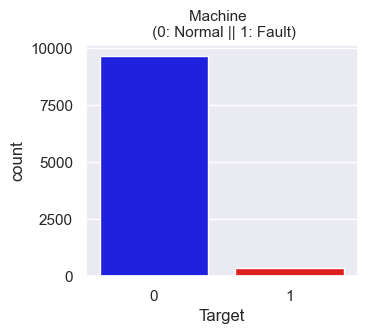

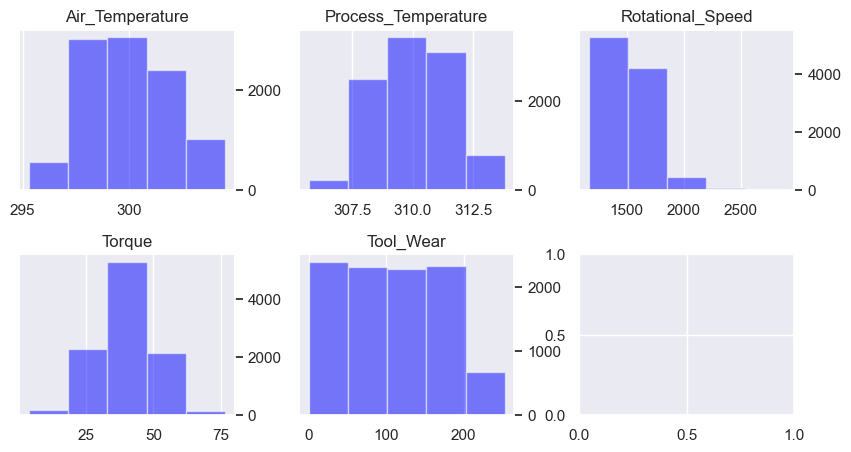

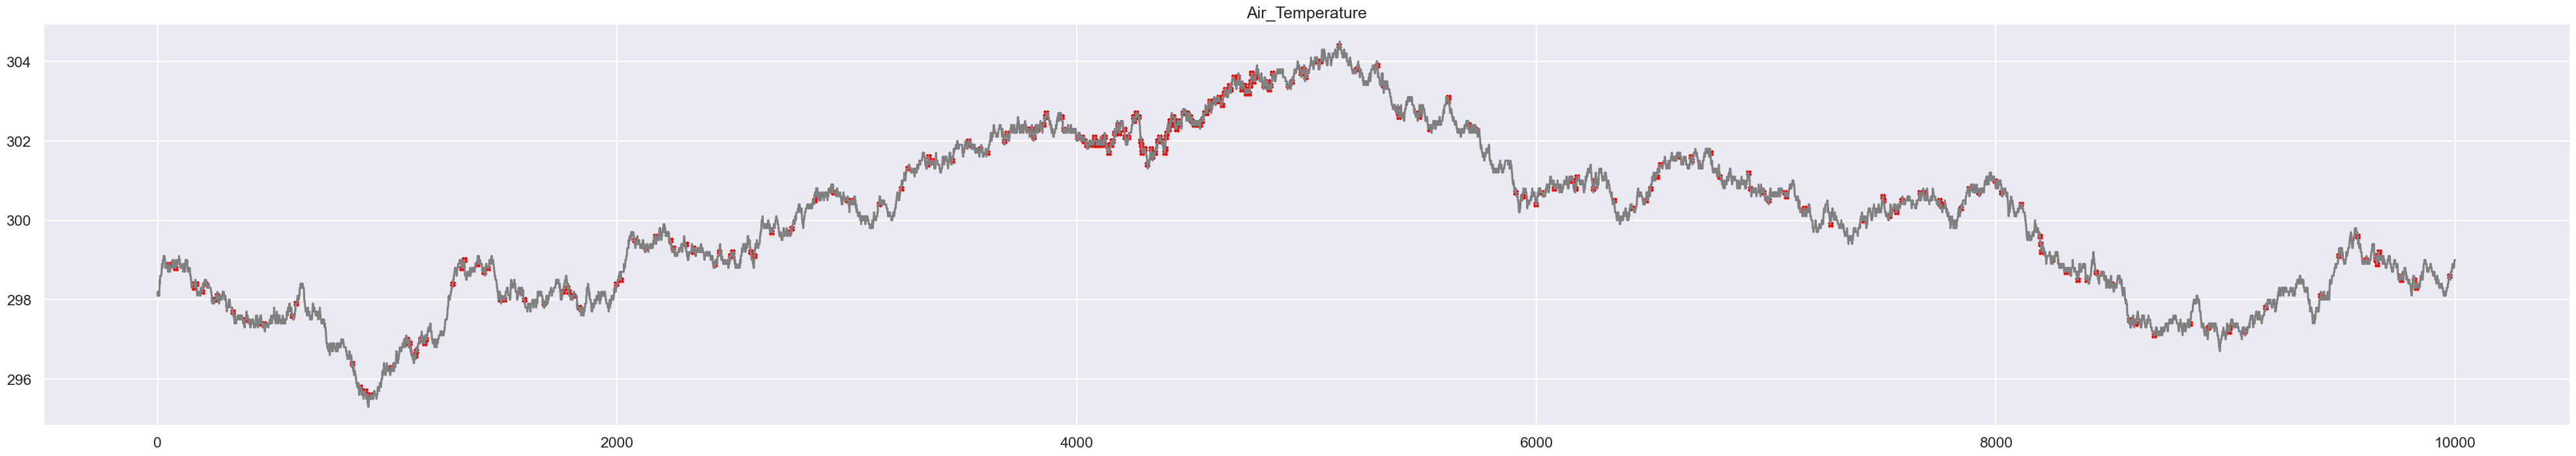

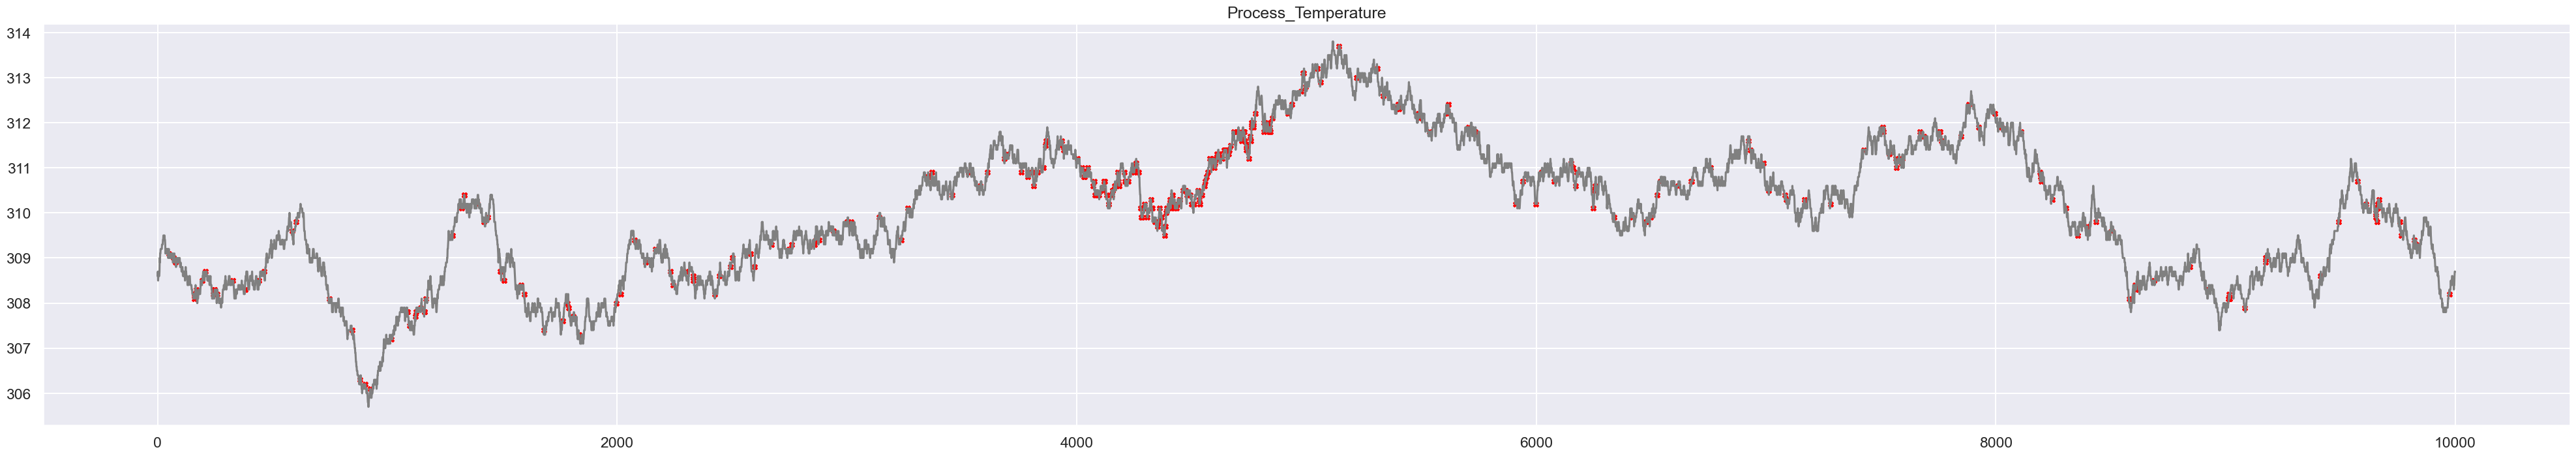

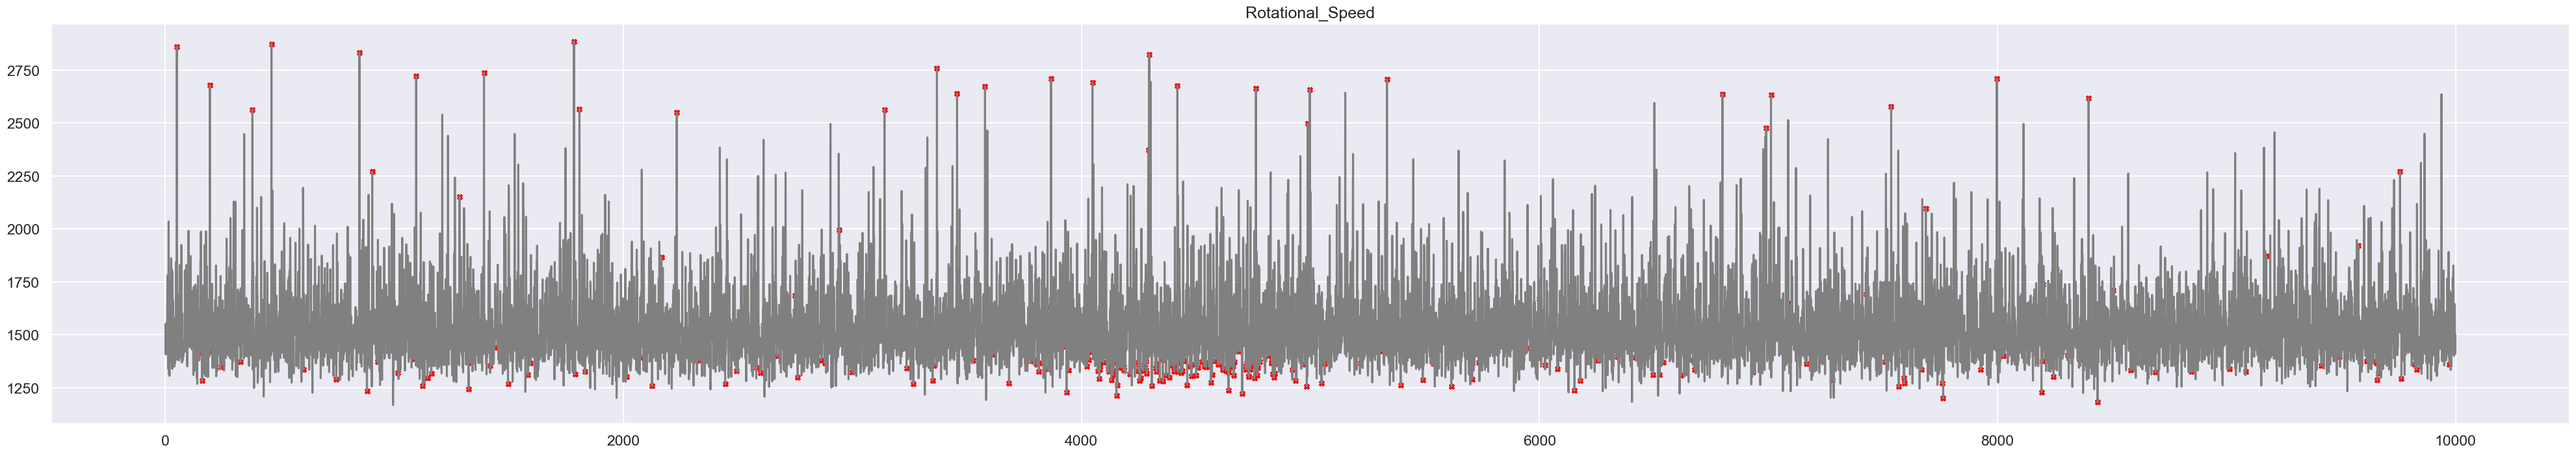

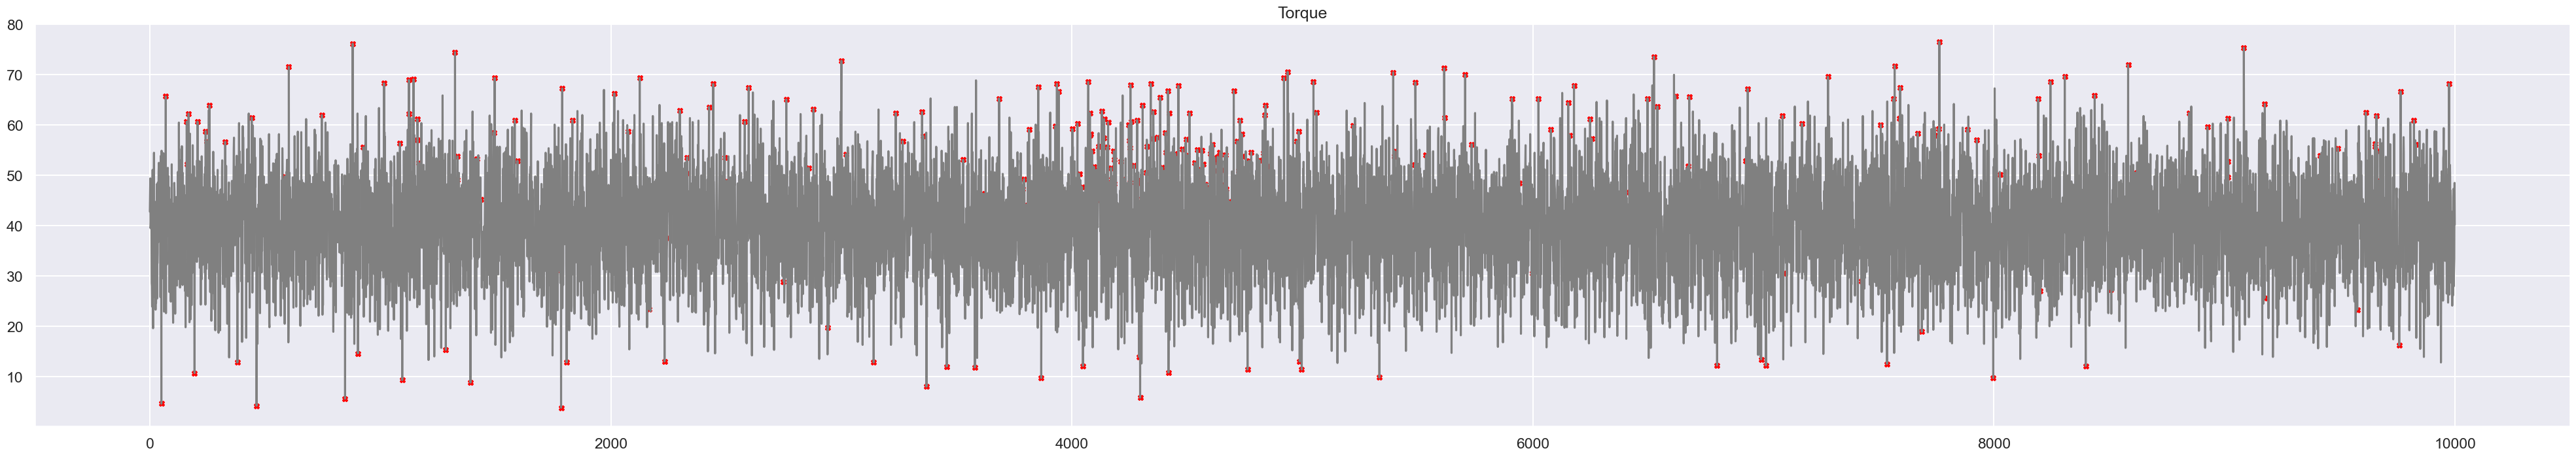

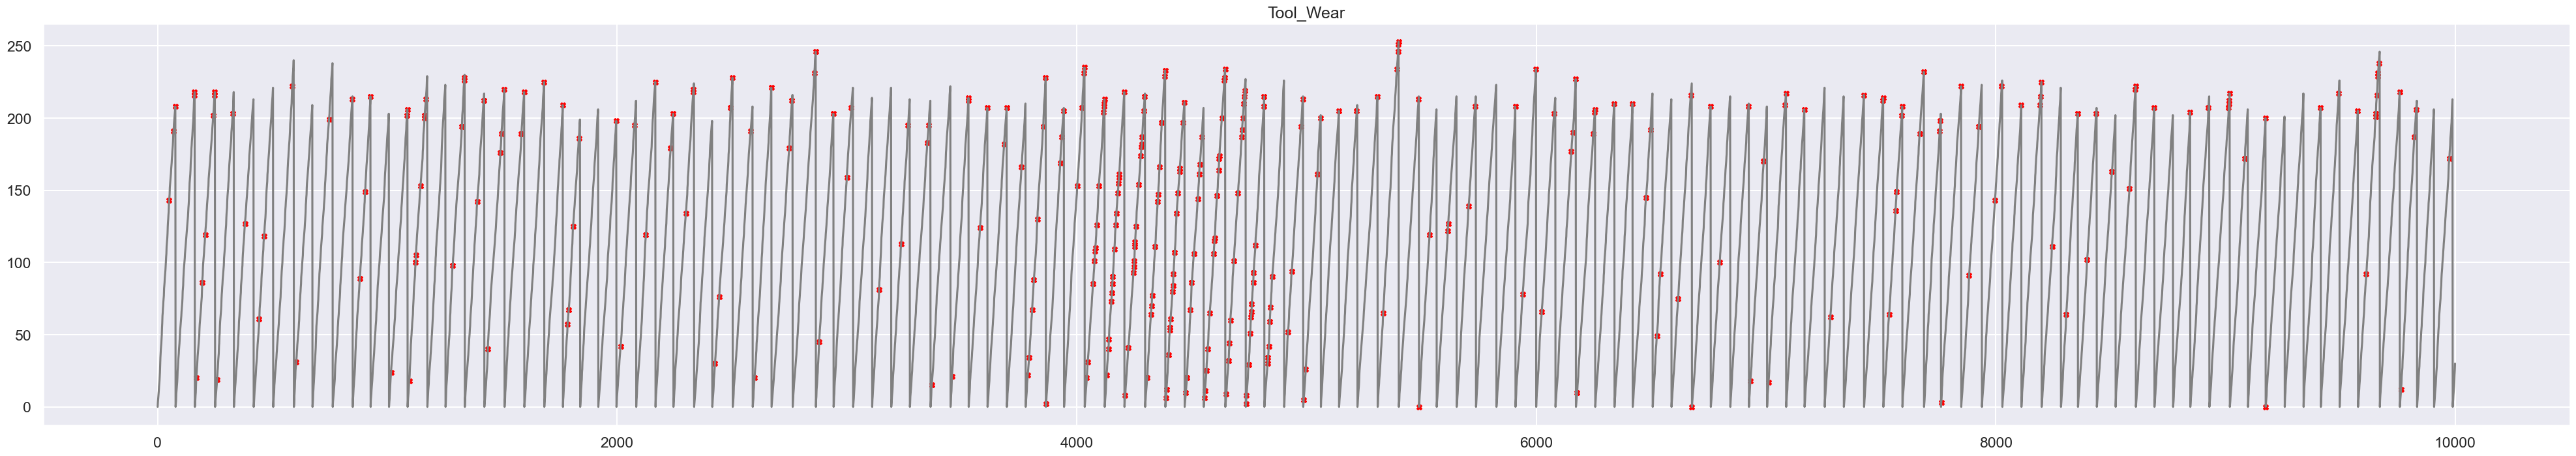





                                 Normality Test                                 


Air_Temperature ShapiroResult(statistic=0.9807750582695007, pvalue=1.3528026355813337e-34) 

Process_Temperature ShapiroResult(statistic=0.9923928380012512, pvalue=1.1303529850749254e-22) 

Rotational_Speed ShapiroResult(statistic=0.8645199537277222, pvalue=0.0) 

Torque ShapiroResult(statistic=0.9997695088386536, pvalue=0.356086790561676) 

Tool_Wear ShapiroResult(statistic=0.9599173665046692, pvalue=0.0) 



In [10]:
Stats, Variable_Explain = Analysis(Data,Target,Input_Data)

In [11]:
Stats

,Air_Temperature,Process_Temperature,Rotational_Speed,Torque,Tool_Wear
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000
std,2.000259,1.483734,179.284096,9.968934,63.654147
min,295.300000,305.700000,1168.000000,3.800000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000
skewness,0.114274,0.015027,1.993171,-0.009517,0.027292
kurtosis,-0.835962,-0.499734,7.392945,-0.013241,-1.166737


In [12]:
Variable_Explain

,Variables,T-Statistic,P-Value,T-Statistic-Welch,P-Value-Welch,Variance Equality F-Test,Corr,VIF_Factor
0,Air_Temperature,-8.283,0.0,-7.982,0.000,0.0,0.082556,4.303979
1,Process_Temperature,-3.597,0.0,-3.898,0.000,0.0,0.035946,4.302788
2,Rotational_Speed,4.423,0.0,2.087,0.038,0.0,-0.044188,4.270132
3,Torque,-19.490,0.0,-11.781,0.000,0.0,0.191321,4.268850
4,Tool_Wear,-10.603,0.0,-9.264,0.000,0.0,0.105448,1.000237


#### 2. 데이터 전처리 

In [13]:
data['Rotational_Speed'] = np.log1p(data['Rotational_Speed'])

(array([0.11835377, 1.92463139, 4.37798337, 2.8769921 , 1.11274666,
        0.41368514, 0.13052098, 0.0553055 , 0.02875886, 0.0221222 ]),
 array([7.06390396, 7.15431088, 7.24471781, 7.33512473, 7.42553165,
        7.51593857, 7.60634549, 7.69675241, 7.78715934, 7.87756626,
        7.96797318]),
 <BarContainer object of 10 artists>)

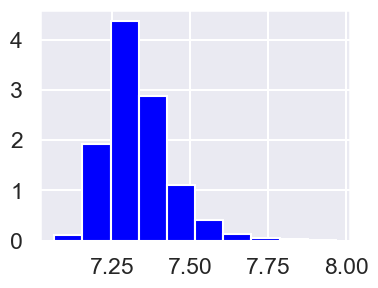

In [14]:
plt.figure(figsize=(4,3)) # 왜도 심한 변수 로그변환 이후 성능 증가 확인 
plt.hist(data['Rotational_Speed'],density=True,color='blue')

In [15]:
Feature_Selection = True

In [16]:
def Train_Test_Split(Feature_Selection):
    
    Data = data
    Input_Data = data.drop(['UDI','Product ID','Type','Target'],axis=1)
    
    X = Input_Data
    y = Data['Target']
    
    if Feature_Selection == False:

        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=2021)
        
        ros_test = RandomUnderSampler(sampling_strategy=0.8,random_state=2021)   
        X_test,y_test = ros_test.fit_resample(X_test,y_test)    

        return X_train, y_train, X_test, y_test
    
    if Feature_Selection == True:
        
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=2021)
        Train = pd.concat([X_train,y_train],axis=1)
        Pass = Train[Train['Target']==0].drop(['Target'],axis=1)
        Fail = Train[Train['Target']==1].drop(['Target'],axis=1)

        T_Test = stats.ttest_ind(Pass,Fail,equal_var=True) # equal_var=True
        Columns = pd.DataFrame(X_train.columns).rename(columns={0:'Columns'})
        P_Value = pd.DataFrame(T_Test[1]).rename(columns={0:'P-Value'})
        Concat_columns_pvalues = pd.concat([Columns,P_Value],axis=1).dropna()

        Significant_Values = Concat_columns_pvalues[Concat_columns_pvalues['P-Value'] < 0.05]['Columns'].to_list()
        df_ttest = Data[Significant_Values]

        X_train,X_test,y_train,y_test = train_test_split(df_ttest,y,test_size=0.2,stratify=y,random_state=2021)
        
        ros_test = RandomUnderSampler(sampling_strategy=0.8,random_state=2021)   
        X_test,y_test = ros_test.fit_resample(X_test,y_test)    

        return X_train, y_train, X_test, y_test 
    
X_train, y_train, X_test, y_test = Train_Test_Split(Feature_Selection)
X_train.shape, X_test.shape

((8000, 5), (153, 5))

In [17]:
y_train.value_counts(),y_test.value_counts()

(0.0    7729
 1.0     271
 Name: Target, dtype: int64,
 0.0    85
 1.0    68
 Name: Target, dtype: int64)

#### 3. ML 

In [18]:
# 활용할 ML 나열 
rf = RandomForestClassifier(random_state=2021)
rf_bal = RandomForestClassifier(random_state=2021,class_weight='balanced')
ada = AdaBoostClassifier(random_state=2021)
gbm = GradientBoostingClassifier(random_state=2021)
xgb = XGBClassifier(random_state=2021)
xgb_bal = XGBClassifier(random_state=2021,scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1])
lgbm =  LGBMClassifier(random_state=2021)
lgbm_bal = LGBMClassifier(random_state=2021,scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1]) 

models = [rf,rf_bal,ada,gbm,xgb,xgb_bal,lgbm,lgbm_bal]

In [19]:
def test_model(model):
        
    X_train, y_train, X_test, y_test = Train_Test_Split(Feature_Selection)
    
    ml = model
    ml.fit(X_train,y_train)      
    pred = ml.predict(X_test)
    pred_proba = ml.predict_proba(X_test)[:,1]
    print('----------------------------------------------------------------------------------------------------------')
    get_clf_eval(y_test,pred,pred_proba)  
    print('\n')
    print(classification_report(y_test, pred,target_names=['양품','불량']))
    
    if model == rf:
        print('RandomForest Prediction Result')
        print('\n')
        
    elif model == rf_bal:
        print('RandomForest(Balanced Weight) Prediction Result')
        print('\n')  
        
    elif model == ada:
        print('AdaBoost Prediction Result')
        print('\n')
     
    elif model == gbm:
        print('GradientBoostingMachine Prediction Result')
        print('\n')
        
    elif model == xgb:
        print('XGBoost Prediction Result')
        print('\n')
        
    elif model == xgb_bal:
        print('XGBoost(Balanced Weight) Prediction Result')
        print('\n')    
        
    elif model == lgbm:
        print('LightGBM Prediction')
        print('\n')   
        
    elif model == lgbm_bal:
        print('LightGBM(Balanced Weight) Prediction Result')

In [20]:
 test_model(models[7]) 

----------------------------------------------------------------------------------------------------------
Confusion Matrix
[[83  2]
 [15 53]]


정확도: 0.889 정밀도: 0.964 재현율: 0.779 AUC: 0.97 F1: 0.862 F2: 0.81 Balanced_Accuracy: 0.878


              precision    recall  f1-score   support

          양품       0.85      0.98      0.91        85
          불량       0.96      0.78      0.86        68

    accuracy                           0.89       153
   macro avg       0.91      0.88      0.88       153
weighted avg       0.90      0.89      0.89       153

LightGBM(Balanced Weight) Prediction Result


In [21]:
# 전체 모델  원큐 출력 
#for i in range(0,len(models)):

#    model = models[i]
#    test_model(model) 

#### 4. Oversampling & ML

In [22]:
def Oversampling_Test(model):
    
    X_train, y_train, X_test, y_test = Train_Test_Split(Feature_Selection)

    for i in list(np.arange(0.65,1.05,0.05).round(2)): # sampling_strategy = 0.65, 0.7 , 0.75, 0.8 ,0.85, 0.9, 0.95, 1.0
        oversampler = SMOTEENN(sampling_strategy=i,random_state=2021)
        X_train_over,y_train_over = oversampler.fit_resample(X_train,y_train)
        ml = model
        ml.fit(X_train_over,y_train_over) 
        pred = ml.predict(X_test)
        pred_proba = ml.predict_proba(X_test)[:,1]
        get_clf_eval(y_test,pred,pred_proba)  
        print('\n')
        print(classification_report(y_test, pred,target_names=['양품','불량']))
        
        if model == rf:
            print('RandomForest SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')
            
        elif model == rf_bal:
            print('RandomForest(Balanced Weight) SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')   

        elif model == ada:
            print('AdaBoost SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')

        elif model == gbm:
            print('GradientBoostingMachine SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')

        elif model == xgb:
            print('XGBoost SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')
            
        elif model == xgb_bal:
            print('XGBoost(Balanced Weight) SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')    


        elif model == lgbm:
            print('LightGBM SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')   
            
        elif model == lgbm_bal:
            print('LightGBM(Balanced Weight) SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')          
            
models = [rf,rf_bal,ada,gbm,xgb,xgb_bal,lgbm,lgbm_bal]

In [23]:
Oversampling_Test(models[3])

Confusion Matrix
[[78  7]
 [ 5 63]]


정확도: 0.922 정밀도: 0.9 재현율: 0.926 AUC: 0.958 F1: 0.913 F2: 0.921 Balanced_Accuracy: 0.922


              precision    recall  f1-score   support

          양품       0.94      0.92      0.93        85
          불량       0.90      0.93      0.91        68

    accuracy                           0.92       153
   macro avg       0.92      0.92      0.92       153
weighted avg       0.92      0.92      0.92       153

GradientBoostingMachine SMOTEENN=0.65 Prediction Result
------------------------------------------------------------------------------------------------------


Confusion Matrix
[[77  8]
 [ 5 63]]


정확도: 0.915 정밀도: 0.887 재현율: 0.926 AUC: 0.957 F1: 0.906 F2: 0.918 Balanced_Accuracy: 0.916


              precision    recall  f1-score   support

          양품       0.94      0.91      0.92        85
          불량       0.89      0.93      0.91        68

    accuracy                           0.92       153
   macro avg       0.91      0.92     

#### 5. Undersampling & ML

In [24]:
def Undersampling_Test(model):
     
    X_train, y_train, X_test, y_test = Train_Test_Split(Feature_Selection)

    for i in list(np.arange(0.65,1.05,0.05).round(2)): # sampling_strategy = 0.65, 0.7 , 0.75, 0.8 ,0.85, 0.9, 0.95, 1.0
        undersampler = RandomUnderSampler(sampling_strategy=i,random_state=2021) 
        #undersampler = NearMiss() --> ROS 이외의 언더샘플링 진행시 for 반복문 해제 
        # TomekLink(), NearMiss, EditedNearestNeigbours,CondensedNearestNeighbour
        
        X_train_under,y_train_under = undersampler.fit_resample(X_train,y_train)
        ml = model
        ml.fit(X_train_under,y_train_under) 
        pred = ml.predict(X_test)
        pred_proba = ml.predict_proba(X_test)[:,1]
        get_clf_eval(y_test,pred,pred_proba)  
        print('\n')
        print(classification_report(y_test, pred,target_names=['양품','불량']))
        
        if model == rf:
            print('RandomForest ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')
            
        elif model == rf_bal:
            print('RandomForest(Balanced Weight) ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')    

        elif model == ada:
            print('AdaBoost ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')

        elif model == gbm:
            print('GradientBoostingMachine ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')

        elif model == xgb:
            print('XGBoost ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')
            
        elif model == xgb_bal:
            print('XGBoost(Balanced Weight) ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')    


        elif model == lgbm:
            print('LightGBM ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')   
            
        elif model == lgbm_bal:
            print('LightGBM(Balanced Weight) ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')          
            
models = [rf,rf_bal,ada,gbm,xgb,xgb_bal,lgbm,lgbm_bal]

In [25]:
Undersampling_Test(models[3])

Confusion Matrix
[[80  5]
 [ 9 59]]


정확도: 0.908 정밀도: 0.922 재현율: 0.868 AUC: 0.95 F1: 0.894 F2: 0.878 Balanced_Accuracy: 0.904


              precision    recall  f1-score   support

          양품       0.90      0.94      0.92        85
          불량       0.92      0.87      0.89        68

    accuracy                           0.91       153
   macro avg       0.91      0.90      0.91       153
weighted avg       0.91      0.91      0.91       153

GradientBoostingMachine ROS=0.65 Prediction Result
------------------------------------------------------------------------------------------------------


Confusion Matrix
[[79  6]
 [ 8 60]]


정확도: 0.908 정밀도: 0.909 재현율: 0.882 AUC: 0.954 F1: 0.896 F2: 0.888 Balanced_Accuracy: 0.906


              precision    recall  f1-score   support

          양품       0.91      0.93      0.92        85
          불량       0.91      0.88      0.90        68

    accuracy                           0.91       153
   macro avg       0.91      0.91      0.9

#### 6. AutoEncoder

In [26]:
def preprocessing():
    
    X_train, y_train, X_test, y_test = Train_Test_Split(Feature_Selection)
    #undersampler = RandomUnderSampler(sampling_strategy=1.0,random_state=2021) 
    #X_train,y_train = undersampler.fit_resample(X_train,y_train)
    
    Train_All = pd.concat([X_train,y_train],axis=1)
    X_train_Normal = Train_All[Train_All['Target']==0].drop(['Target'],axis=1)

    scaler = MinMaxScaler()
    scaler.fit(X_train_Normal) # Train Data 기준으로 Train/Test 스케일링 진행 

    X_train_Normal = pd.DataFrame(scaler.transform(X_train_Normal),columns = X_train_Normal.columns)
    X_test = pd.DataFrame(scaler.transform(X_test),columns = X_test.columns)
    
    return X_train_Normal, X_test , y_train ,y_test

X_train_Normal, X_test , y_train ,y_test = preprocessing()

In [27]:
X_train_Normal.shape, X_test.shape

((7729, 5), (153, 5))

In [28]:
y_train.value_counts(),y_test.value_counts()

(0.0    7729
 1.0     271
 Name: Target, dtype: int64,
 0.0    85
 1.0    68
 Name: Target, dtype: int64)

In [29]:
def build_autoencoder(X,outer,inner,latent_vector,function,dropout_ratio):
    
    random.seed(1234)
    np.random.seed(1234)
    tf.random.set_seed(1234)
    
    input_layer = Input(shape = (X.shape[1],))
    
    encoded = Dense(outer, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(input_layer)
    encoded = Dropout(dropout_ratio)(encoded)
    encoded = Dense(inner, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(encoded)
    
    encoded = Dense(latent_vector, activation = function)(encoded) 
    
    decoded = Dense(inner, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(encoded)
    decoded = Dropout(dropout_ratio)(decoded)
    decoded = Dense(outer, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(decoded)
    
    output_layer = Dense(X.shape[1], activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(decoded)

    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

In [30]:
def train_autoencoder(model,X,batch,epoch,val,patience):
    history = model.fit(X, X,
                              batch_size = batch, epochs = epoch, 
                              validation_split = val,callbacks=EarlyStopping(patience=patience))
    
    print('\n')
    sns.set(font_scale=1.0)
    plt.figure(figsize=(6,4))
    plt.grid(True)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='valid loss')
    plt.legend()
    plt.xlabel('Epoch'); plt.ylabel('loss')
    plt.show()

    return history 

In [31]:
X = X_train_Normal

outer = 62
inner = 30
latent_vector = 8
dropout_ratio = 0.2
function = 'relu'

batch = 85
epoch = 300
val = 0.2
patience = 10

Epoch 1/300
73/73 [==============================] - 1s 4ms/step - loss: 0.1194 - val_loss: 0.0319
Epoch 2/300
73/73 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.0289
Epoch 3/300
73/73 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0256
Epoch 4/300
73/73 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0232
Epoch 5/300
73/73 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0229
Epoch 6/300
73/73 [==============================] - 0s 2ms/step - loss: 0.0247 - val_loss: 0.0229
Epoch 7/300
73/73 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0227
Epoch 8/300
73/73 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0225
Epoch 9/300
73/73 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0225
Epoch 10/300
73/73 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0223
Epoch 11/

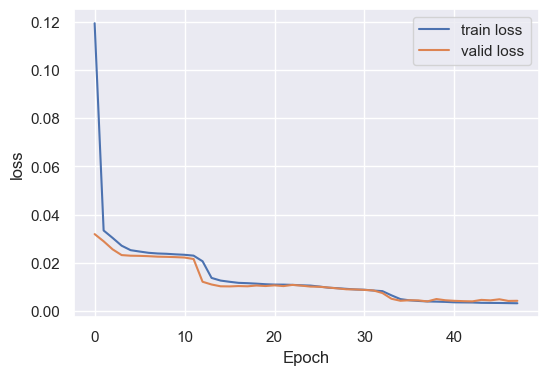

In [32]:
autoencoder = build_autoencoder(X,outer,inner,latent_vector,function,dropout_ratio)

history = train_autoencoder(autoencoder,X,batch,epoch,val,patience)

In [33]:
def reconstruction_loss(model,x_train,x_test):
    
    x_train_pred  = model.predict(x_train)
    x_test_pred = model.predict(x_test)
    
    train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

    print('\n')
    plt.figure(figsize=(6,4))
    plt.title('Reconstruction MAE Loss')
    plt.hist(train_mae_loss, bins=40,color='blue',density=True,label='Train')
    plt.hist(test_mae_loss, bins=40,color='red',density=True,label='Test')
    plt.legend()
    plt.show()

    threshold_train = np.max(train_mae_loss) 
    threshold_test = np.max(test_mae_loss) 
    print('\n')
    print("Train (Normal Only) Reconstruction error threshold:", threshold_train)
    print('\n')
    print("Test Reconstruction error threshold:", threshold_test)
    
    #anomalies = threshold_test > threshold_train
    #print('\n')
    #print("Train Threshold Based Detected Anomalies: ", np.sum(anomalies))
    #print("Real Normal Labels from Test Data : ", y_test.value_counts()[0])
    #print("Real Fault Labels from Test Data : ", y_test.value_counts()[1])
    
    return train_mae_loss, test_mae_loss, threshold_train, threshold_test

5/5 [==============================] - 0s 997us/step




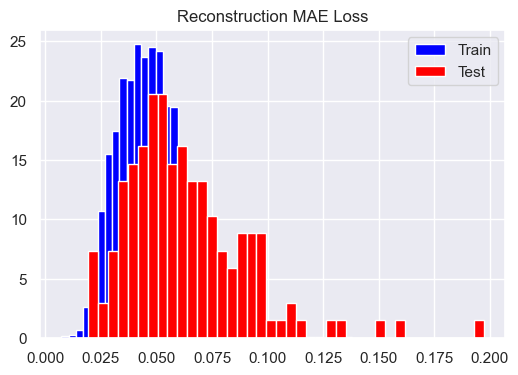



Train (Normal Only) Reconstruction error threshold: 0.13793608230715573


Test Reconstruction error threshold: 0.19749979577977747


In [34]:
train_mae_loss, test_mae_loss, threshold_train, threshold_test = reconstruction_loss(autoencoder,X_train_Normal,X_test)

In [35]:
def anomaly_threshold(threshold,model):
    test_score_df = pd.DataFrame(X_test[:])
    test_score_df['loss'] = test_mae_loss # --> pred_proba
    test_score_df['threshold'] = threshold # 레이블 예측 임계값 
    test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
    test_score_df['score'] = test_score_df["anomaly"].astype(int) # 예측 레이블 
    get_clf_eval(y_test,test_score_df['score'],test_score_df['loss'])
    print('\n')
    print(classification_report(y_test, test_score_df['score'],target_names=['양품','불량']))
    
    test_error = pd.DataFrame({'Reconstruction_error': test_mae_loss,'True_class': y_test.reset_index()['Target']})

    plt.figure(figsize=(4, 3))
    plt.title(model, fontsize=12)
    plt.scatter(test_error.index[test_error['True_class'] == 0],test_error[test_error['True_class'] == 0]['Reconstruction_error'], s = 10, label = 'Normal')
    plt.scatter(test_error.index[test_error['True_class'] == 1],test_error[test_error['True_class'] == 1]['Reconstruction_error'], s = 10, label = 'Fault')
    plt.xlabel('Count', fontsize=10)
    plt.ylabel('Mean Absolute Error (MAE)', fontsize=10)
    plt.axhline(threshold,color = 'red', ls = '--', label = 'Threshold = %0.2f' % (threshold))
    plt.legend(bbox_to_anchor=(1.0, 1.03))
    plt.show()

In [36]:
threshold_train

0.13793608230715573

Confusion Matrix
[[62 23]
 [10 58]]


정확도: 0.784 정밀도: 0.716 재현율: 0.853 AUC: 0.859 F1: 0.779 F2: 0.822 Balanced_Accuracy: 0.791


              precision    recall  f1-score   support

          양품       0.86      0.73      0.79        85
          불량       0.72      0.85      0.78        68

    accuracy                           0.78       153
   macro avg       0.79      0.79      0.78       153
weighted avg       0.80      0.78      0.78       153



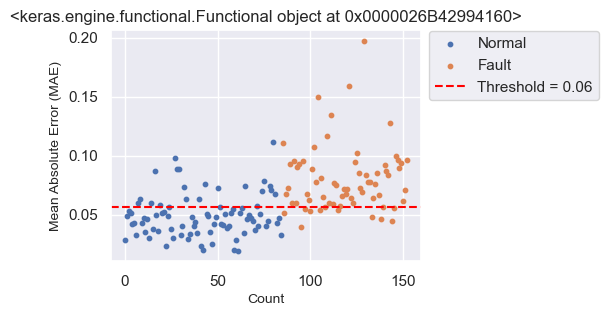

In [37]:
anomaly_threshold(threshold = 0.056, model=autoencoder)

In [38]:
#for i in range(0,len(test_mae_loss)):
    
    
#    anomaly_threshold(test_mae_loss[i],'Autoencoder')
#    print('threshold'+ ' = ' + str(test_mae_loss[i]))
#    print('-----------------------------------------------------------------------------------------')
#    print('\n')